In [60]:
%matplotlib inline
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## About the Data:

This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The data in a rows belongs to the houses found in a given California district.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


You can notice that
* *total_bedroom* has only 20433 non-null values, 
* *ocean_proximity* is an object type, i.e. contents a text values because we read it from csv



In [5]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


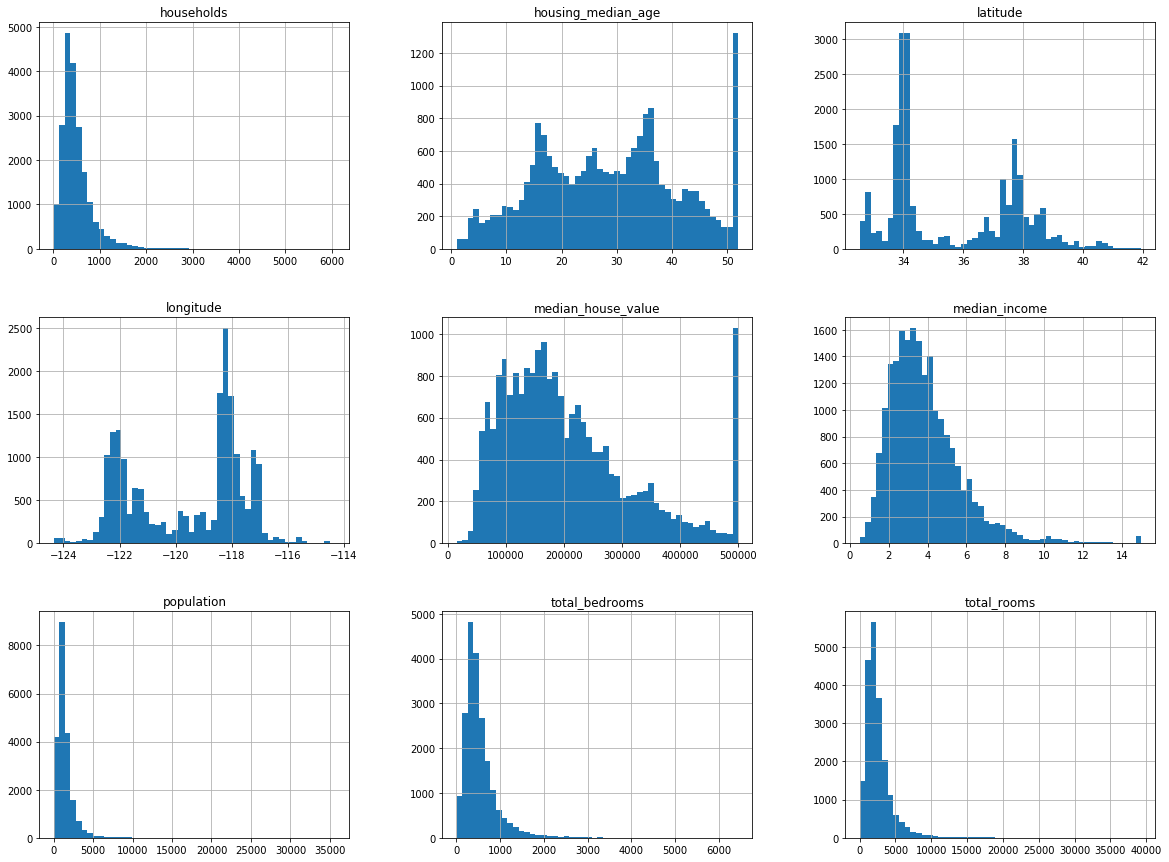

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Notable:
* *median_income* was limited (min 0.4999 and max 15.0001). After figuring out I found that median income was measured in tens of thousands Dollars
* *housing_median_age* and *median_house_value* were also limited
* attributes have very different scales
* many histograms are heavy tailed

## Splitting Data into Training and Test Sets

I figured out that Median Income is the most important attribute in house price predicting. 

After looking up on *median_income* histogram I have noticed that most of the values are grouped in \\$20 000 - \\$50 000 range, but some districts has income much higher than \\$60 000. 

In order to increase the representativeness of splitting data I will use a **stratified sampling**. But there should be enough samples in strata. So I first decreased the number of categories from 15 to 10 and then united all categories that are higher than 5 into category 5.

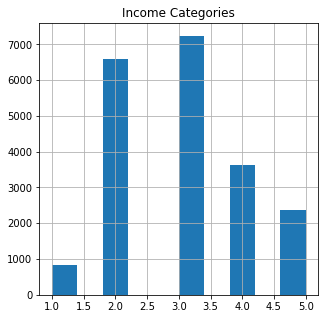

In [8]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].hist(figsize=(5,5))
plt.title('Income Categories')
plt.show()

In [9]:
# Stratified Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Random Split    
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=11)

In [10]:
overall_coef = housing['income_cat'].value_counts() / len(housing)

train_set_table = overall_coef.to_frame().rename(columns={'income_cat':'Overall'})
train_set_table['Random'] = train_set['income_cat'].value_counts() / len(train_set)
train_set_table['Stratified'] = strat_train_set['income_cat'].value_counts() / len(strat_train_set)
train_set_table['Rand. %error'] = 100 - (train_set_table.Random / train_set_table.Overall)*100
train_set_table['Strat. %error'] = 100 - (train_set_table.Stratified / train_set_table.Overall)*100

train_set_table.sort_index()

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.041546,0.039850,-4.318735,-0.060827
2.0,0.318847,0.320312,0.318859,-0.459657,-0.003799
3.0,0.350581,0.349867,0.350594,0.203842,-0.003455
4.0,0.176308,0.174176,0.176296,1.209123,0.006870
5.0,0.114438,0.114099,0.114402,0.296359,0.031753


It is clear that Stratified Train Set is more close to original data. 
So now I can drop out *income_cat* column.

In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    
    
housing = strat_train_set.copy()

## Analyzing Patterns

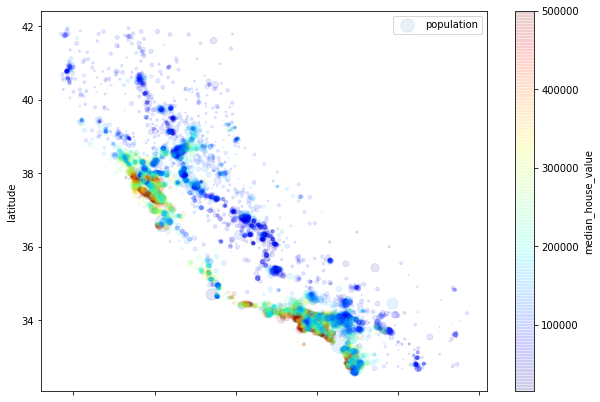

In [12]:
housing.plot(kind="scatter", 
             x="longitude", y="latitude", s=housing["population"]/100, c="median_house_value", 
             label="population", cmap=plt.get_cmap("jet"), alpha=0.1, figsize=(10,7))
plt.show()

In [13]:
# Linear correlations
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687819
total_rooms           0.136257
housing_median_age    0.100173
households            0.066018
total_bedrooms        0.050808
population           -0.026287
longitude            -0.042994
latitude             -0.148049
Name: median_house_value, dtype: float64

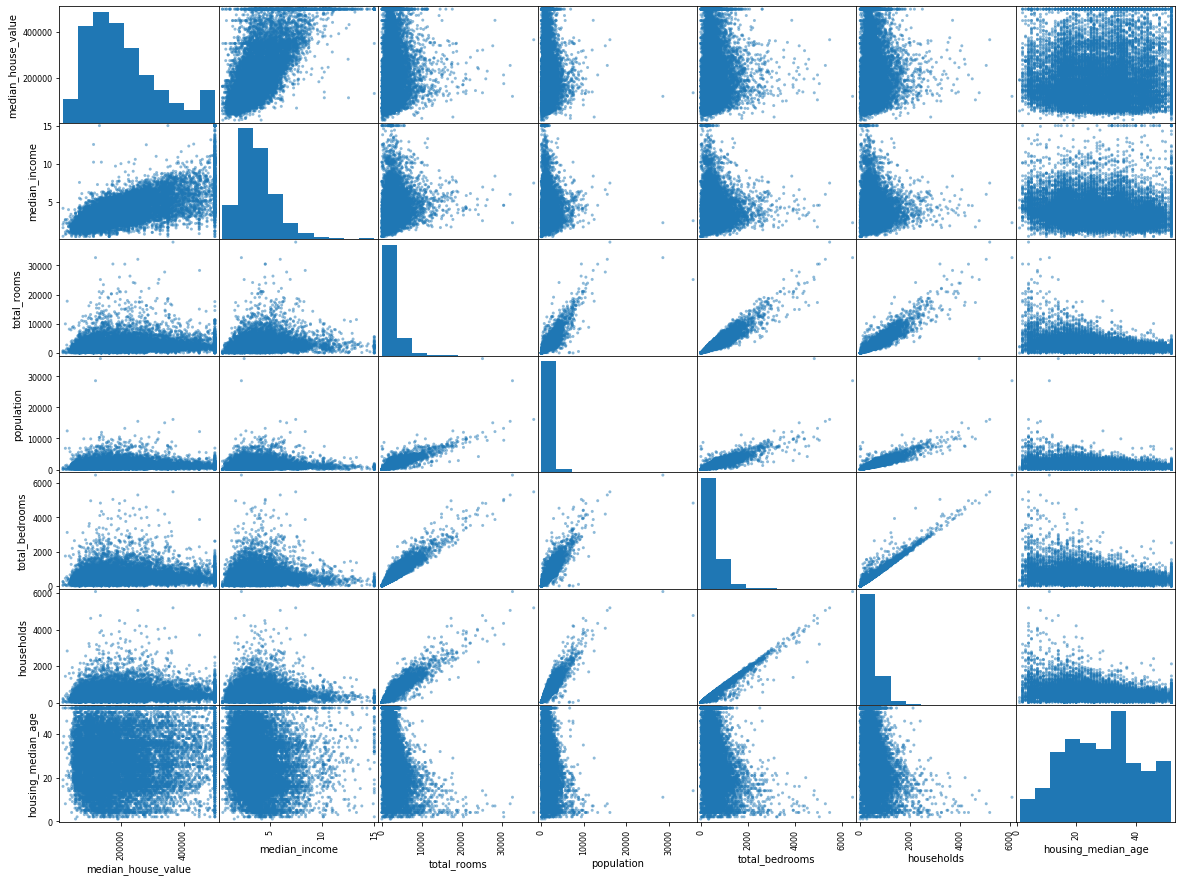

In [14]:
attributes = ["median_house_value", "median_income", "total_rooms", "population", "total_bedrooms", "households", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(20,15))
plt.show()

Interesting correlations:
* total_bedrooms / total_rooms
* population / households
* total_rooms / households

And interesting but meaningless correlation between population and number of rooms 

In [15]:
# Meaningless: housing["population_per_rooms"] = housing["total_rooms"] / housing["population"]
housing["bedrooms_per_rooms"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687819
rooms_per_household         0.172885
total_rooms                 0.136257
housing_median_age          0.100173
households                  0.066018
total_bedrooms              0.050808
population_per_household   -0.022291
population                 -0.026287
longitude                  -0.042994
latitude                   -0.148049
bedrooms_per_rooms         -0.260035
Name: median_house_value, dtype: float64

New features looks very promising.

## Data Pipeline

1. Autocomplete missing (nan) values
2. Add combined features 
3. Normalize data
4. Vectorize text categories

In [16]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]
housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [17]:
# Custom transformer: adds combined features to DataFrame
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, 
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

In [18]:
# Custom transformer: separates num and category (text) data
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values

Creating pipeline:

In [19]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# Converting text categories into one-hot vectors:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('encoder', OneHotEncoder())
])


# Final pipeline
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [20]:
housing_prepared = full_pipeline.fit_transform(housing)

# Final data:
#np.set_printoptions(threshold=np.inf)
housing_prepared.toarray()

array([[ 0.88692303, -0.91195641, -1.24191428, ...,  0.        ,
         0.        ,  0.        ],
       [-1.16335311,  0.5635916 , -0.52656888, ...,  0.        ,
         0.        ,  1.        ],
       [-0.91392779,  1.39942417,  0.74515627, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71731381, -0.71583927,  1.85791578, ...,  0.        ,
         0.        ,  0.        ],
       [-1.35291636,  1.04921499,  1.85791578, ...,  0.        ,
         1.        ,  0.        ],
       [-1.03365195,  0.6896669 , -1.16243146, ...,  0.        ,
         0.        ,  0.        ]])

## Selecting and Training ML Model

#### Trying Linear Regression

In [47]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predicted:", lin_reg.predict(some_data_prepared))
print("Real prices:", list(some_labels))

Predicted: [188446.87634719 217822.7224687   83876.69336204 116932.35799495
 195090.38928635]
Real prices: [333300.0, 300000.0, 64400.0, 134200.0, 118200.0]


Seems that predictions are not so good. Let's calculate *root mean square error*:

In [34]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Linear regression error:", lin_rmse, "dollars")

Linear regression error: 68376.58316280936 dollars


I guess we faced an underfitting (high bias) problem. We can plot a Jcost function or try a more complicated model:

#### Trying Decision Tree

In [48]:

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Tree decision error:", tree_rmse, "dollars")

Tree decision error: 0.0 dollars


Now we faced an overfitting (high-variance) issue, and our new model may have worser performace.

To see the real error (it can't be 0.0) I will use **N-fold cross-validation** 

In [39]:
# 10-fold cross validation
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [40]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69026.96380226 70856.35888272 69307.93690242 74833.12576808
 71160.07182632 74362.51941619 69681.46550939 70922.70222246
 67159.76102516 71881.38297368]
Mean: 70919.22883286777
Standard deviation: 2236.182791438604


As it was expected the real error is much higher than zero and seems bigger than linear regression has.

In [45]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [67946.3470989  72043.62662231 66935.91383247 69505.87155323
 70581.05235081 70161.98711528 65314.14210328 70476.91194145
 66917.30709135 67533.81660618]
Mean: 68741.69763152614
Standard deviation: 2008.1599900795386


#### Trying Random Forest

In [50]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores: [51642.14113726 54554.3126739  52038.54175823 54179.27367654
 53405.96513933 54032.02833347 49998.45810835 52971.87091596
 51682.81317906 53502.8215551 ]
Mean: 52800.82264772096
Standard deviation: 1356.6792746719145


Much better

#### Trying Support Vector Machine

In [54]:
sv_reg = SVR(gamma="scale")
sv_reg.fit(housing_prepared, housing_labels)

svr_scores = cross_val_score(sv_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [115817.13630567 119569.78231458 116178.80817563 119964.96780719
 118248.41522161 116494.99550982 118018.64904415 121433.26020033
 121469.37772426 115071.39681839]
Mean: 118226.67891216229
Standard deviation: 2205.0121471811026


## Tuning

In [64]:
param_grid = [
    {'n_estimators': [30, 40, 50], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [60, 70], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [65]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 70}

In [68]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

52690.710931668116 {'max_features': 2, 'n_estimators': 30}
52013.80100913944 {'max_features': 2, 'n_estimators': 40}
51941.275921202134 {'max_features': 2, 'n_estimators': 50}
50602.60429747369 {'max_features': 4, 'n_estimators': 30}
50327.60204145312 {'max_features': 4, 'n_estimators': 40}
49847.07206016134 {'max_features': 4, 'n_estimators': 50}
50242.79921118614 {'max_features': 6, 'n_estimators': 30}
49868.28791447789 {'max_features': 6, 'n_estimators': 40}
49854.09782535737 {'max_features': 6, 'n_estimators': 50}
50058.75504345834 {'max_features': 8, 'n_estimators': 30}
50104.3298654105 {'max_features': 8, 'n_estimators': 40}
49837.54403172305 {'max_features': 8, 'n_estimators': 50}
50728.74274794686 {'bootstrap': False, 'max_features': 2, 'n_estimators': 60}
50727.65174116834 {'bootstrap': False, 'max_features': 2, 'n_estimators': 70}
49423.74836541188 {'bootstrap': False, 'max_features': 3, 'n_estimators': 60}
49524.46909220128 {'bootstrap': False, 'max_features': 3, 'n_estimato

In [100]:
# Printing Feature Importances
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["encoder"]
cat_1h_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_1h_attribs
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.28055254727161266, 'median_income'),
 (0.13346894504266443, 'INLAND'),
 (0.10211609153185182, 'pop_per_hhold'),
 (0.09044476146876343, 'longitude'),
 (0.0833481098214685, 'bedrooms_per_room'),
 (0.08176447109111556, 'latitude'),
 (0.07357649913008338, 'rooms_per_hhold'),
 (0.04009399059380117, 'housing_median_age'),
 (0.021291079105877058, 'population'),
 (0.021196957180484508, 'total_rooms'),
 (0.020169072784699198, '<1H OCEAN'),
 (0.019580667913525404, 'total_bedrooms'),
 (0.018631500526597247, 'households'),
 (0.008321090852376969, 'NEAR OCEAN'),
 (0.005144983631591817, 'NEAR BAY'),
 (0.0002992320534869341, 'ISLAND')]

## Testing

In [105]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"]

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [106]:
display_scores(final_rmse)

Scores: 47671.87677797656
Mean: 47671.87677797656
Standard deviation: 0.0
